In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_multitaper
from scipy import stats
import pandas as pd
import matplotlib.patches as mpatches
from pathlib import Path
%matplotlib qt

Effective window size : 4.096 (s)


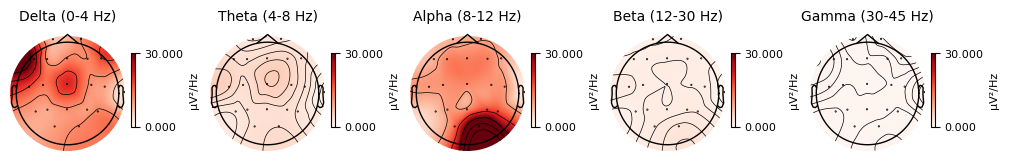

In [2]:
# 1) EDF 읽기
raw = mne.io.read_raw_edf(
    './EEG_arithmetic_task/Subject00_1.edf',
    preload=True,
    verbose=False
)

raw.rename_channels(lambda x: x.replace('EEG ', ''))

# ECG 채널 제거
raw.drop_channels(['ECG ECG'])

raw.rename_channels({'A2-A1':'A2'})

raw.set_montage('standard_1020')

raw.compute_psd().plot_topomap(ch_type='eeg', vlim=(0, 30))

In [ ]:
raw.plot(block=True)

Using matplotlib as 2D backend.
Channels marked as bad:
none


Effective window size : 4.096 (s)


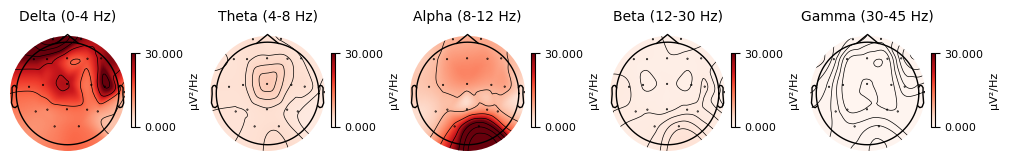

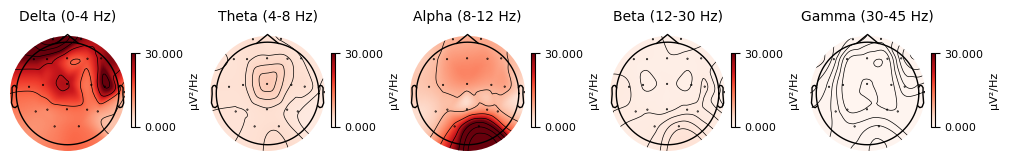

In [15]:
# 1) EDF 읽기
raw = mne.io.read_raw_edf(
    './EEG_arithmetic_task/Subject00_2.edf',
    preload=True,
    verbose=False
)

raw.rename_channels(lambda x: x.replace('EEG ', ''))

# ECG 채널 제거
raw.drop_channels(['ECG ECG'])

raw.rename_channels({'A2-A1':'A2'})

raw.set_montage('standard_1020')

raw.compute_psd().plot_topomap(ch_type='eeg', vlim=(0, 30))

In [3]:
# 설정 부분
base_dir = os.path.join(os.getcwd(), "EEG_arithmetic_task")  # 데이터가 저장된 디렉토리 경로 설정
subjects = [f"Subject{i:02d}" for i in range(36)]  # Subject00부터 Subject35까지
conditions = ["1", "2"]  # 01: 휴식상태, 02: Mental arithmetic task
channels_of_interest = ["EEG P3", "EEG P4", "EEG Pz", "EEG Fz"]  # 관심 채널
frequency_bands = {
    "theta": (4, 8),
    "alpha": (8, 13)
}


# 결과 저장용 데이터프레임 초기화
results = []

# 진행 상황 추적
total_files = len(subjects) * len(conditions) 
processed_files = 0

In [ ]:
# 각 피험자별로 처리
for subject in subjects:
    # 피험자별 결과 저장
    subject_data = {}
    
    for condition in conditions:
        filename = f"{subject}_{condition}.edf"  # 파일 이름 형식에 맞게 조정
        file_path = os.path.join(base_dir, filename)
        
        # 파일 존재 여부 확인
        if not os.path.exists(file_path):
            print(f"파일을 찾을 수 없음: {file_path}")
            continue
        
        try:
            # EEG 데이터 로드
            raw = mne.io.read_raw_edf(file_path, preload=True)
            
            # 60Hz 노치 필터 적용 (전원 노이즈 제거)
            raw.notch_filter(freqs=60)
            
            # 1-45Hz 대역 필터 적용
            raw.filter(l_freq=1, h_freq=45)
            
            # 관심 채널만 선택
            raw.pick_channels(channels_of_interest)
            
            # 채널별 PSD (Power Spectral Density) 계산
            fmin, fmax = 2, 40  # 주파수 범위
            psd = raw.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
            psds = psd.get_data()
            freqs = psd.freqs
            
            # 조건별로 데이터 저장
            subject_data[condition] = {
                'raw': raw,
                'psds': psds,
                'freqs': freqs
            }
            
            # 진행 상황 업데이트
            processed_files += 1
            print(f"처리 중: {processed_files}/{total_files} - {subject}_{condition}")
            
        except Exception as e:
            print(f"파일 처리 중 오류 발생: {file_path}")
            print(f"오류 메시지: {str(e)}")
    
    # 조건 01과 02가 모두 있는 경우에만 ERD/ERS 계산
    if '1' in subject_data and '2' in subject_data:
        # 각 채널 및 주파수 대역에 대해 ERD/ERS 계산
        for ch_idx, channel in enumerate(channels_of_interest):
            for band_name, (band_min, band_max) in frequency_bands.items():
                # 해당 주파수 대역의 인덱스 찾기
                freq_idx = np.logical_and(
                    subject_data['1']['freqs'] >= band_min,
                    subject_data['1']['freqs'] <= band_max
                )
                
                # 각 조건에서 평균 파워 계산
                power_rest = np.mean(subject_data['1']['psds'][ch_idx, freq_idx])
                power_task = np.mean(subject_data['2']['psds'][ch_idx, freq_idx])
                
                # ERD/ERS 계산 (휴식 상태 대비 변화율, %)
                # ERD는 음수, ERS는 양수로 표현됨
                erd_ers = ((power_rest - power_task) / power_rest) * 100
                
                # 결과 저장
                results.append({
                    'subject': subject,
                    'channel': channel,
                    'band': band_name,
                    'power_rest': power_rest,
                    'power_task': power_task,
                    'erd_ers': erd_ers
                })
    else:
        print(f"{subject}: 휴식 또는 작업 상태 데이터가 누락되었습니다.")

In [5]:
# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results)

# subject-info.csv 읽어서 Count quality 정보 병합
subject_info = pd.read_csv(os.path.join(base_dir, "subject-info.csv"))
subject_info = subject_info[["Subject", "Count quality"]]
df_results = df_results.merge(subject_info, left_on="subject", right_on="Subject", how="left")
df_results = df_results.drop(columns=["Subject"])  # 중복 컬럼 제거

# 결과 저장
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)
df_results.to_csv(os.path.join(results_dir, "erd_ers_results.csv"), index=False)

In [6]:
# 시각화
def plot_erd_ers_by_band_and_channel():
    """주파수 대역과 채널별 ERD/ERS 결과 시각화"""
    plt.figure(figsize=(14, 10))
    
    for band_idx, band in enumerate(frequency_bands.keys()):
        plt.subplot(len(frequency_bands), 1, band_idx + 1)
        
        # 채널별 결과 추출
        band_data = df_results[df_results['band'] == band]
        
        # 채널별 평균 ERD/ERS 계산
        channel_means = band_data.groupby('channel')['erd_ers'].mean()
        channel_sems = band_data.groupby('channel')['erd_ers'].sem()
        


        # 색상 지정: ERD(음수)는 빨간색, ERS(양수)는 파란색
        colors = ['red' if val < 0 else 'blue' for val in channel_means.values]

        
        # 바 그래프 그리기
        bars = plt.bar(channel_means.index, channel_means.values, color=colors)
        
        # 오차 막대 추가
        for i, (_, sem) in enumerate(channel_sems.items()):
            plt.errorbar(i, channel_means.iloc[i], yerr=sem, fmt='none', color='black', capsize=5)
        
        # 축 설정
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        plt.title(f'{band.capitalize()} band ERD/ERS', fontsize=14)
        plt.ylabel('ERD/ERS (%)')
        plt.ylim(-50, 50)  # 적절하게 조정

        # 범례 추가
        erd_patch = mpatches.Patch(color='red', label='ERS')
        ers_patch = mpatches.Patch(color='blue', label='ERD')
        plt.legend(handles=[erd_patch, ers_patch], loc='upper right')
        
        # 각 채널에 대한 paired t-test 수행
        for i, channel in enumerate(channels_of_interest):
            ch_data = band_data[band_data['channel'] == channel]
            t_stat, p_val = stats.ttest_1samp(ch_data['erd_ers'].values, 0)
            
            # p-value 표시
            significance = ""
            if p_val < 0.001:
                significance = "***"
            elif p_val < 0.01:
                significance = "**"
            elif p_val < 0.05:
                significance = "*"
                
            if significance:
                plt.text(i, channel_means.iloc[i] + (5 if channel_means.iloc[i] >= 0 else -10), 
                         significance, ha='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "erd_ers_by_band_and_channel.png"))
    plt.close()

In [7]:
def plot_erd_ers_by_band_and_channel_grouped():
    """Count quality 그룹별로 ERD/ERS 시각화"""
    for group in [0, 1]:
        group_data = df_results[df_results["Count quality"] == group]
        if group_data.empty:
            continue
        plt.figure(figsize=(14, 10))


        for band_idx, band in enumerate(frequency_bands.keys()):
            plt.subplot(len(frequency_bands), 1, band_idx + 1)

            band_data = group_data[group_data['band'] == band]

            channel_means = band_data.groupby('channel')['erd_ers'].mean()
            channel_sems = band_data.groupby('channel')['erd_ers'].sem()

            colors = ['red' if val < 0 else 'blue' for val in channel_means.values]
            bars = plt.bar(channel_means.index, channel_means.values, color=colors)


            for i, (_, sem) in enumerate(channel_sems.items()):
                plt.errorbar(i, channel_means.iloc[i], yerr=sem, fmt='none', color='black', capsize=5)


            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            plt.title(f'{band.capitalize()} band ERD/ERS (Count quality={group})', fontsize=14)
            plt.ylabel('ERD/ERS (%)')
            plt.ylim(-50, 50)
            erd_patch = mpatches.Patch(color='red', label='ERS')
            ers_patch = mpatches.Patch(color='blue', label='ERD')
            plt.legend(handles=[erd_patch, ers_patch], loc='upper right')


            for i, channel in enumerate(channels_of_interest):
                ch_data = band_data[band_data['channel'] == channel]
                t_stat, p_val = stats.ttest_1samp(ch_data['erd_ers'].values, 0)

                significance = ""
                if p_val < 0.001:
                    significance = "***"
                elif p_val < 0.01:
                    significance = "**"
                elif p_val < 0.05:
                    significance = "*"

                if significance:
                    plt.text(i, channel_means.iloc[i] + (5 if channel_means.iloc[i] >= 0 else -10), significance, ha='center')


        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"erd_ers_by_band_and_channel_group{group}.png"))
        plt.close()

In [8]:
import numpy as np

def plot_erd_ers_by_band_and_channel_group_compare():
    """Count quality 그룹별 ERD/ERS를 한 그래프에서 비교 시각화"""
    group_labels = [0, 1]
    group_colors = ['#66CDAA', '#FFB90F'] 
    group_names = ['Count quality=0', 'Count quality=1']

    plt.figure(figsize=(14, 10))
    bar_width = 0.35
    x = np.arange(len(channels_of_interest))

    for band_idx, band in enumerate(frequency_bands.keys()):
        plt.subplot(len(frequency_bands), 1, band_idx + 1)
        means = []
        sems = []
        for group in group_labels:
            group_data = df_results[(df_results["Count quality"] == group) & (df_results['band'] == band)]
            channel_means = group_data.groupby('channel')['erd_ers'].mean().reindex(channels_of_interest)
            channel_sems = group_data.groupby('channel')['erd_ers'].sem().reindex(channels_of_interest)
            means.append(channel_means)
            sems.append(channel_sems)
        # 막대 위치 조정
        plt.bar(x - bar_width/2, means[0], bar_width, yerr=sems[0], color=group_colors[0], label=group_names[0], capsize=5)
        plt.bar(x + bar_width/2, means[1], bar_width, yerr=sems[1], color=group_colors[1], label=group_names[1], capsize=5)
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        plt.title(f'{band.capitalize()} band ERD/ERS', fontsize=14)
        plt.ylabel('ERD/ERS (%)')
        plt.xticks(x, channels_of_interest)
        plt.ylim(-50, 50)
        plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "erd_ers_by_band_and_channel_group_compare.png"))
    plt.show()

In [10]:
def plot_time_frequency_maps():
    """시간-주파수 분석 맵 생성 (하나의 대표 피험자 사용)"""
    # 대표 피험자 선택 (첫 번째로 완전한 데이터를 가진 피험자)
    representative_subject = None
    for subject in subjects:
        if subject in set(df_results['subject']):
            representative_subject = subject
            break
    
    if representative_subject is None:
        print("시간-주파수 맵을 생성할 유효한 피험자를 찾을 수 없습니다.")
        return
    
    print(f"시간-주파수 맵 생성에 사용할 대표 피험자: {representative_subject}")
    
    # 해당 피험자의 데이터 파일 다시 로드
    for condition_name, condition in zip(['휴식', '인지작업'], conditions):
        filename = f"{representative_subject}_{condition}.edf"
        file_path = os.path.join(base_dir, filename)
        
        if not os.path.exists(file_path):
            print(f"파일을 찾을 수 없음: {file_path}")
            continue
        
        try:
            # 데이터 로드
            raw = mne.io.read_raw_edf(file_path, preload=True)
            raw.filter(l_freq=1, h_freq=45)
            
            # 관심 채널만 선택
            raw.pick_channels(channels_of_interest)
            
            # 시간-주파수 분석 (멀티테이퍼 방법)
            freqs = np.arange(4, 20, 1)  # theta와 alpha 대역을 포함하는 주파수
            n_cycles = freqs / 2.  # 낮은 주파수에는 더 적은 사이클 사용
            
            # 에포크로 변환 (연속 데이터를 10초 단위로 분할)
            duration = 10.0  # 초 단위
            events = mne.make_fixed_length_events(raw, duration=duration)
            epochs = mne.Epochs(raw, events, tmin=0, tmax=duration, baseline=None, preload=True)
            
            # 시간-주파수 분석
            power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, 
                                  time_bandwidth=4.0, return_itc=False, average=True)
            
            # 각 채널별로 플롯
            fig = power.plot_joint(baseline=None, mode='mean', 
                                 timefreqs=[(5, 6), (10, 10)],  # (time, frequency) 쌍
                                 title=f'{representative_subject} - {condition_name} 상태의 시간-주파수 지도')
            
            # 저장
            plt.savefig(os.path.join(results_dir, f"tf_{representative_subject}_{condition}.png"))
            # 그래프 표시
            plt.show()
            
        except Exception as e:
            print(f"시간-주파수 맵 생성 중 오류 발생: {str(e)}")

In [11]:
# 통계 분석: 각 주파수 대역과 채널에 대한 그룹 수준의 t-검정
def run_statistical_analysis():
    """각 주파수 대역과 채널에 대한 통계 분석 수행"""
    stats_results = []
    
    for band in frequency_bands.keys():
        for channel in channels_of_interest:
            # 해당 대역 및 채널에 대한 데이터 추출
            data = df_results[(df_results['band'] == band) & 
                             (df_results['channel'] == channel)]
            
            # t-검정 수행 (ERD/ERS가 0과 유의하게 다른지)
            t_stat, p_val = stats.ttest_1samp(data['erd_ers'].values, 0)
            
            # 효과 크기 계산 (Cohen's d)
            effect_size = np.mean(data['erd_ers']) / np.std(data['erd_ers'])
            
            # 결과 저장
            stats_results.append({
                'band': band,
                'channel': channel,
                'mean_erd_ers': data['erd_ers'].mean(),
                'std_erd_ers': data['erd_ers'].std(),
                't_statistic': t_stat,
                'p_value': p_val,
                'effect_size': effect_size,
                'significant': p_val < 0.05
            })
    
    # 결과를 데이터프레임으로 변환
    df_stats = pd.DataFrame(stats_results)
    
    # 결과 저장
    df_stats.to_csv(os.path.join(results_dir, "statistical_results.csv"), index=False)
    
    # 결과 출력
    print("\n통계 분석 결과:")
    print(df_stats[['band', 'channel', 'mean_erd_ers', 'p_value', 'significant']])
    
    return df_stats

Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters fro

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject05_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
A

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject07_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) re

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject09_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure..

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject11_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject13_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject15_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject17_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject19_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject21_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
A

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject25_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject26_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters fro

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject29_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject31_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 39999  =      0.000 ...    79.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject33_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject02_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters fro

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 conti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject09_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject13_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject16_2.edf...
EDF file detected
Setting channel info structur

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject19_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 conti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject22_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject24_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters fro

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject28_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 conti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject31_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject34_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


AttributeError: 'collections.OrderedDict' object has no attribute 'ndim'

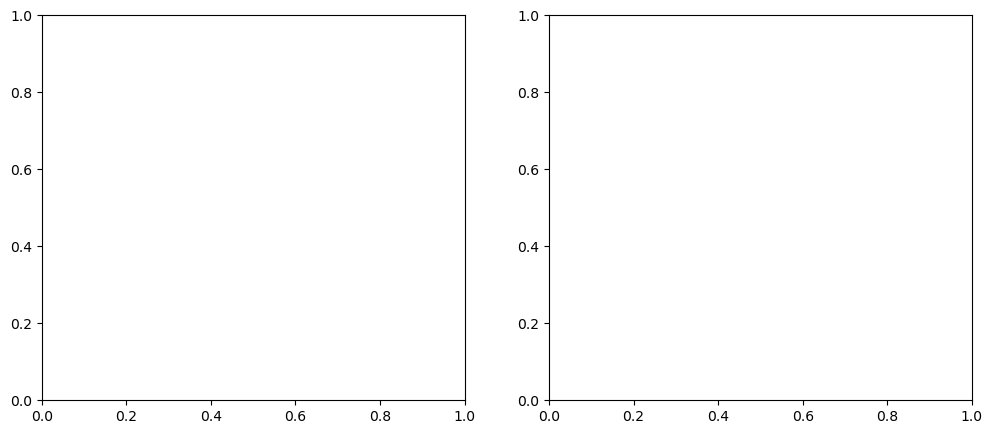

In [39]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

# 1. 설정: 데이터 디렉터리와 파일 패턴
data_dir = './EEG_arithmetic_task'
pattern1 = lambda fn: fn.endswith('_1.edf')
pattern2 = lambda fn: fn.endswith('_2.edf')

# 2. 파일 리스트 취득
files = sorted([f for f in os.listdir(data_dir) if f.endswith('.edf')])
group1_files = [f for f in files if pattern1(f)]
group2_files = [f for f in files if pattern2(f)]

# 3. PSD 계산 함수 (Raw.compute_psd 사용)
def compute_mean_psd(file_list, fmin=1, fmax=40, tmin=None, tmax=None):
    if not file_list:
        raise ValueError("파일 리스트가 비어 있습니다. 경로와 패턴을 확인하세요.")
    psd_list = []
    freqs = None
    for fname in file_list:
        raw = mne.io.read_raw_edf(os.path.join(data_dir, fname), preload=True)
        raw.set_eeg_reference('average', projection=False)
        raw.filter(fmin, fmax, fir_design='firwin')
        psd = raw.compute_psd(fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, n_fft=2048, picks='eeg')
        data = psd.get_data()
        freqs = psd.freqs
        psd_list.append(np.mean(data, axis=1))
    return np.mean(psd_list, axis=0), freqs

# 4. 평균 PSD 계산
group1_psd, freqs = compute_mean_psd(group1_files)
group2_psd, _ = compute_mean_psd(group2_files)

# 5. Montage 불러오기 및 위치 정보 추출
montage = mne.channels.make_standard_montage('standard_1020')
pos = montage.get_positions()['ch_pos']
# pos: dict, key=채널 이름, value=xyz 위치

# 6. Topomap 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Group 1 (suffix _1)
mne.viz.plot_topomap(group1_psd, pos, axes=axes[0], show=False)
axes[0].set_title('Group _1 Average PSD')

# Group 2 (suffix _2)
mne.viz.plot_topomap(group2_psd, pos, axes=axes[1], show=False)
axes[1].set_title('Group _2 Average PSD')

plt.suptitle('PSD Topographic Comparison (_1 vs _2)')
plt.tight_layout()
plt.show()
